# Comparing Networks

In this notebook, we want to compare different network to each other.
This one focuses on...

- Generator Machine Unlearning*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ GEMU: The implemented algorithm is not the same as the one in the paper. While the paper focused on unlearning specific classes, we are training to unlearn a subset of a class, tied together by a feature, which distinguish it from the rest.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [1]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np
# from helper import get_model TODO Muss überarbeitet werden
from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

5413

In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [3]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
        weights_only=True
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [4]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [5]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Generator Machine Unlearning

In [6]:
from unlearning import unlearn_n_models, GeneratorMachineUnlearning
from training import save_model

In [7]:
# Train a single model first
if not ALLREADY_TRAINED:
    sga = GeneratorMachineUnlearning(
        model=trained_showcase_all,
        dataset_name=USED_DATASET,
    )
    mu_showcase = sga.unlearn()
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [8]:
if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_data,
        dataset_name=USED_DATASET,
        which_unlearning="GeneratorMachineUnlearning",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}test_ensemble")

___
### Exact Model

In [9]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [10]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [11]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Untrained to ...

In [12]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.63372439990441

In [13]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

849.7748464226722

In [14]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

27.624756759032607

#### Trained to ...

In [15]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

850.4156629323959

In [16]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

28.4165061848859

#### GEMU to ...

In [17]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

850.4722546299298

#### Exact to ...

In [18]:
# see above

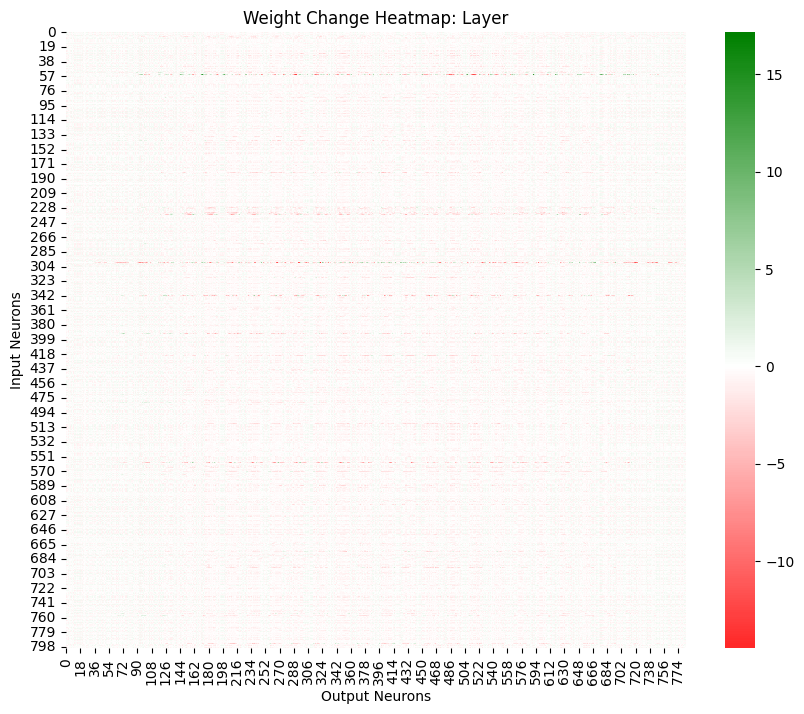

In [19]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[1].fc1.weight, weights_after=mu_ms[1].fc1.weight)

### Layer-wise Distance

In [19]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), mu_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'fc1.weight': 442315.14166666666,
 'fc1.bias': 754.4992431640625,
 'fc3.weight': 3486.675602213542,
 'fc3.bias': 6.682090775171916}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [20]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [21]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.0466936451205475

#### Trained to...

In [22]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6624442890855053

#### Exact to...

In [23]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6603894756073319

#### MU to...

In [24]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

8.377854142207811

In [25]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.392336584734013

In [26]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

3.3908271809037487

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [35]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'mnist'...


Average accuracy for D_gesamt: 0.8368 - Standard Deviation for D_gesamt: 0.0261


Average accuracy for D_remain: 0.8526 - Standard Deviation for D_remain: 0.0259


Average accuracy for 0: 0.9123 - Standard Deviation for 0: 0.0215


Average accuracy for 1: 0.9528 - Standard Deviation for 1: 0.0143


Average accuracy for 2: 0.7941 - Standard Deviation for 2: 0.0372


Average accuracy for 3: 0.7975 - Standard Deviation for 3: 0.0250


Average accuracy for 4: 0.8312 - Standard Deviation for 4: 0.0330


Average accuracy for 5: 0.7390 - Standard Deviation for 5: 0.1431


Average accuracy for 6: 0.8983 - Standard Deviation for 6: 0.0239


Average accuracy for 8: 0.9603 - Standard Deviation for 8: 0.0090


Average accuracy for 9: 0.7717 - Standard Deviation for 9: 0.2038


Average accuracy for 7_all: 0.6974 - Standard Deviation for 7_all: 0.1079


Average accuracy for 7_remain: 0.8288 - Standard Deviation for 7_remain: 0.1382


Average accuracy for 7_erased: 0.6768 - Standard Deviation for 7_erased: 0.1044
plotting...


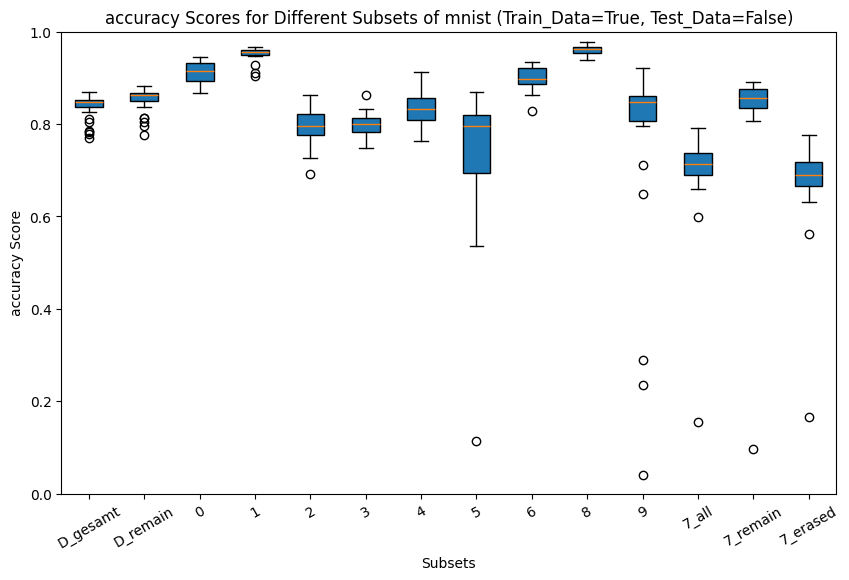

In [36]:
accs["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average accuracy for D_gesamt: 0.8404 - Standard Deviation for D_gesamt: 0.0265


Average accuracy for D_remain: 0.8534 - Standard Deviation for D_remain: 0.0267


Average accuracy for 0: 0.9331 - Standard Deviation for 0: 0.0222


Average accuracy for 1: 0.9583 - Standard Deviation for 1: 0.0169


Average accuracy for 2: 0.8033 - Standard Deviation for 2: 0.0351


Average accuracy for 3: 0.8165 - Standard Deviation for 3: 0.0273


Average accuracy for 4: 0.8164 - Standard Deviation for 4: 0.0310


Average accuracy for 5: 0.7436 - Standard Deviation for 5: 0.1431


Average accuracy for 6: 0.8868 - Standard Deviation for 6: 0.0272


Average accuracy for 8: 0.9516 - Standard Deviation for 8: 0.0117


Average accuracy for 9: 0.7686 - Standard Deviation for 9: 0.2031


Average accuracy for 7_all: 0.7114 - Standard Deviation for 7_all: 0.1101


Average accuracy for 7_remain: 0.7410 - Standard Deviation for 7_remain: 0.1306


Average accuracy for 7_erased: 0.7068 - Standard Deviation for 7_erased: 0.1081
plotting...


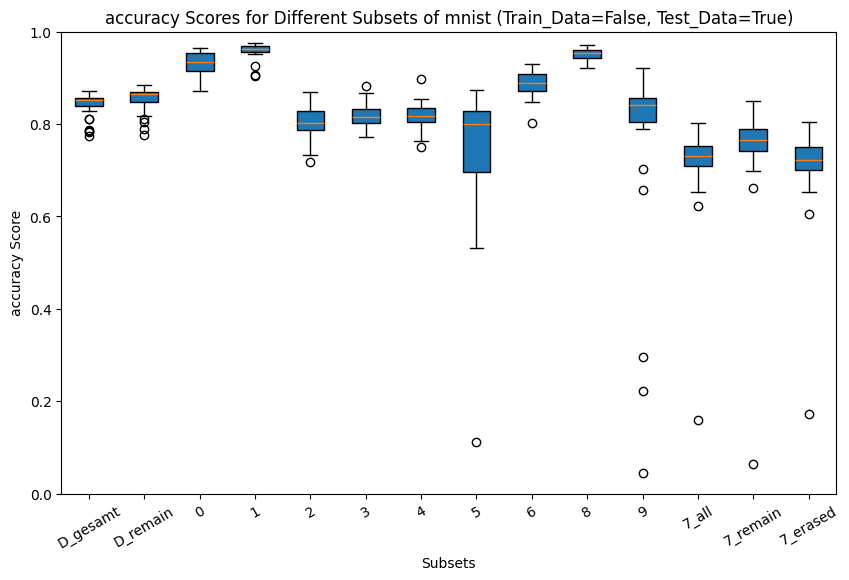

In [37]:
accs["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [38]:
losses = {}

Starts evaluation for 'mnist'...


Average loss for D_gesamt: 0.1660 - Standard Deviation for D_gesamt: 0.0232


Average loss for D_remain: 0.1246 - Standard Deviation for D_remain: 0.0087


Average loss for 0: 0.0793 - Standard Deviation for 0: 0.0188


Average loss for 1: 0.0652 - Standard Deviation for 1: 0.0265


Average loss for 2: 0.1580 - Standard Deviation for 2: 0.0288


Average loss for 3: 0.1367 - Standard Deviation for 3: 0.0223


Average loss for 4: 0.1097 - Standard Deviation for 4: 0.0188


Average loss for 5: 0.1590 - Standard Deviation for 5: 0.0422


Average loss for 6: 0.0965 - Standard Deviation for 6: 0.0209


Average loss for 8: 0.2137 - Standard Deviation for 8: 0.0458


Average loss for 9: 0.1248 - Standard Deviation for 9: 0.0362


Average loss for 7_all: 0.5119 - Standard Deviation for 7_all: 0.2122


Average loss for 7_remain: 0.0582 - Standard Deviation for 7_remain: 0.0186


Average loss for 7_erased: 0.5830 - Standard Deviation for 7_erased: 0.2449
plotting...


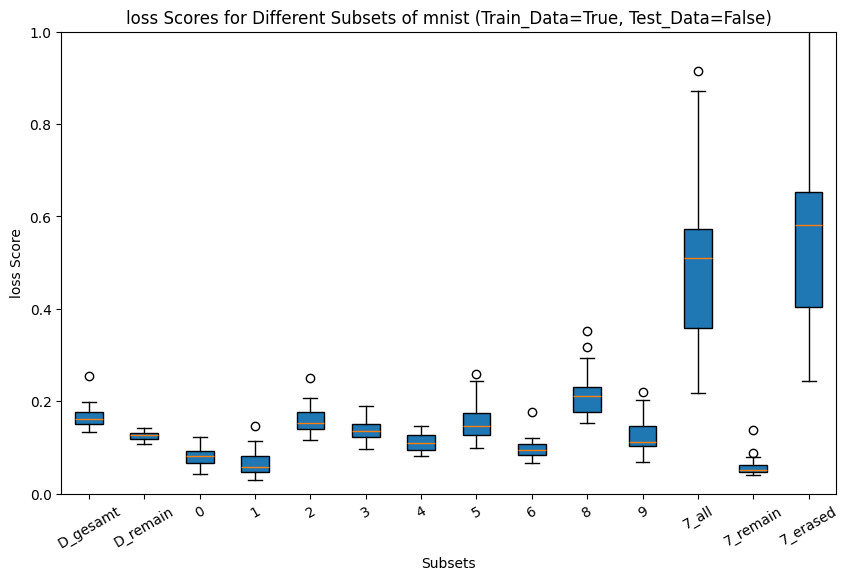

In [39]:
losses["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average loss for D_gesamt: 0.1657 - Standard Deviation for D_gesamt: 0.0231


Average loss for D_remain: 0.1407 - Standard Deviation for D_remain: 0.0129


Average loss for 0: 0.1064 - Standard Deviation for 0: 0.0350


Average loss for 1: 0.0545 - Standard Deviation for 1: 0.0206


Average loss for 2: 0.1410 - Standard Deviation for 2: 0.0304


Average loss for 3: 0.1127 - Standard Deviation for 3: 0.0259


Average loss for 4: 0.1090 - Standard Deviation for 4: 0.0237


Average loss for 5: 0.1467 - Standard Deviation for 5: 0.0431


Average loss for 6: 0.1659 - Standard Deviation for 6: 0.0406


Average loss for 8: 0.2992 - Standard Deviation for 8: 0.0677


Average loss for 9: 0.1421 - Standard Deviation for 9: 0.0408


Average loss for 7_all: 0.3894 - Standard Deviation for 7_all: 0.1700


Average loss for 7_remain: 0.1813 - Standard Deviation for 7_remain: 0.0676


Average loss for 7_erased: 0.4219 - Standard Deviation for 7_erased: 0.1929
plotting...


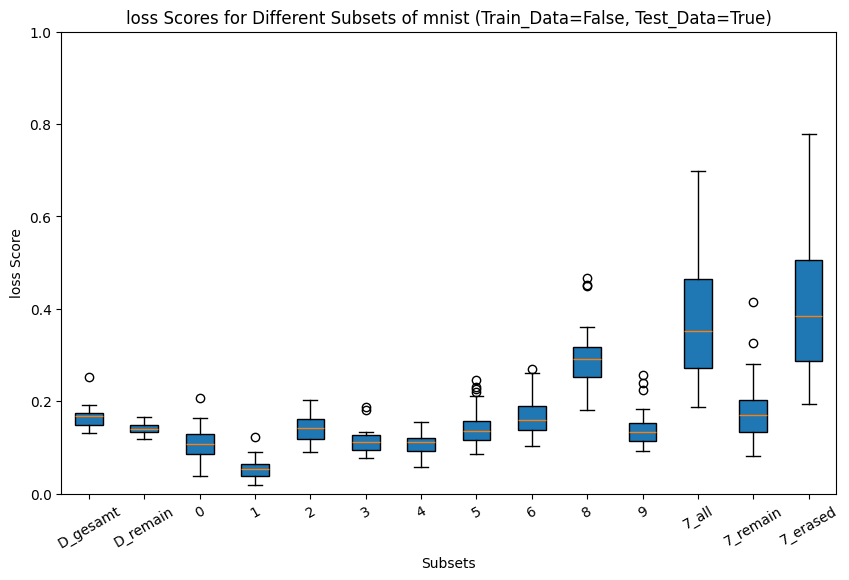

In [40]:
losses["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=False, test_split=True, logs=True)